# Load all the necessary packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re
from collections import defaultdict
import json
from datetime import datetime
import tweepy

import nltk
from nltk import pos_tag
from nltk.corpus import wordnet as wn
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from sklearn.feature_extraction.text import CountVectorizer

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('vader_lexicon')

%matplotlib inline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


/usr/local/lib/python3.6/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


# Set the credentials to authenticate access to Twitter

In [2]:
consumer_key = 'xxxx'
consumer_key_secret = 'xxxx'
access_token = 'xxxx'
access_token_secret = 'xxxx'

auth = tweepy.OAuthHandler(consumer_key, consumer_key_secret)

auth.set_access_token(access_token, access_token_secret)

api = tweepy.API(auth)

# Define the function to extract tweets and select only the relevant columns

In [3]:
def extract_tweets(screen_name, num_tweets):
  # Extract the tweets using the extended mode and specified number of tweets
  tweets = api.user_timeline(screen_name=screen_name,
                            tweet_mode='extended',
                            count=num_tweets)

  list_of_dicts = []
  tweet_list = []
  for json_tweet in tweets:
    # Save the json tweets in a list
    tweet_dict = json_tweet._json
    list_of_dicts.append(tweet_dict)

    # Check if the tweet contains photos (note that videos are not included)
    with_photo = False
    try:
        for medium in tweet_dict['extended_entities']['media']:
            if medium['type'] == 'photo':
                with_photo = True
                break
    except:
        pass

    # Create a list with the relevant columns only
    tweet_list.append({'text': str(tweet_dict['full_text']),
                       'created_at': datetime.strftime(datetime.strptime(tweet_dict['created_at'],'%a %b %d %H:%M:%S +0000 %Y'), '%Y-%m-%d %H:%M:%S'),
                       'count_hashtags': len(tweet_dict['entities']['hashtags']),
                       'user': tweet_dict['user']['screen_name'],
                       'with_link': len(tweet_dict['entities']['urls']) > 0,
                       'with_photo': with_photo,
                      })
  
  # Create the data frame containing the tweets
  df = pd.DataFrame(tweet_list)
  df['created_at'] = pd.to_datetime(df['created_at'])
  # Extract the date of the tweet
  df['date'] = [dt.date().strftime('%d-%m-%Y') for dt in df['created_at']]
  # Extract the hour the tweet was made
  df['hour'] = [dt.time().strftime('%H:00') for dt in df['created_at']]
  # Create a column that checks if the tweet contains links or photos
  df['with_link_or_photo'] = df['with_link'] | df['with_photo']

  return list_of_dicts, df

Get the tweets of Alexandria Ocasio-Cortez (American politician) and Kim Kardashian (celebrity) and combine them in one data frame.

In [4]:
max_tweets = 200
user_1 = 'AOC'
user_2 = 'KimKardashian'

list_aoc, df_aoc = extract_tweets(user_1, max_tweets)
list_kkw, df_kkw = extract_tweets(user_2, max_tweets)
df = pd.concat([df_aoc, df_kkw], ignore_index=True)

Save the raw tweets as json file and tweets with selected columns as csv files.

In [5]:
with open('tweet_aoc.json', mode = 'w') as file:
  file.write(json.dumps(list_aoc, indent=4))

with open('tweet_kkw.json', mode = 'w') as file:
  file.write(json.dumps(list_kkw, indent=4))

df_aoc.to_csv('tweet_aoc.csv', index=False)
df_kkw.to_csv('tweet_kkw.csv', index=False)

# **Question 1**: Posting Times of the Tweets for the Two Users

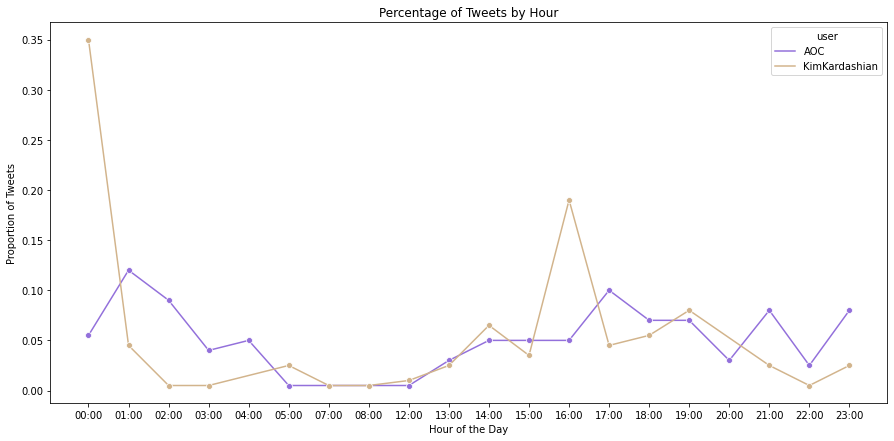

In [6]:
fig, ax = plt.subplots(figsize=(15, 7))

df_time = df.groupby(['user', 'hour']).count().reset_index()[['user', 'hour', 'text']]
df_time['tweet_pct'] = df_time['text'] / df_time.groupby('user')['text'].transform('sum')
df_time = df_time.sort_values('hour').reset_index()

ax = sns.lineplot(data=df_time, x='hour', y='tweet_pct', hue='user', marker='o', palette=['mediumpurple', 'tan'])
_ = ax.set(xlabel='Hour of the Day', ylabel='Proportion of Tweets', title='Percentage of Tweets by Hour')

Kim Kardashian posts tweets at 00:00 (EST) while tweets of Alexandria Ocasio-Cortez is evenly spread throughout the day. It is worth noting that there aren't any Twitter activities for the two users between 6:00 to 7:00 and 8:00 to 12:00 (EST) which probably corresponds to their sleeping time.

# **Question 2**: Proportions of Tweets That Contain Pictures or Links

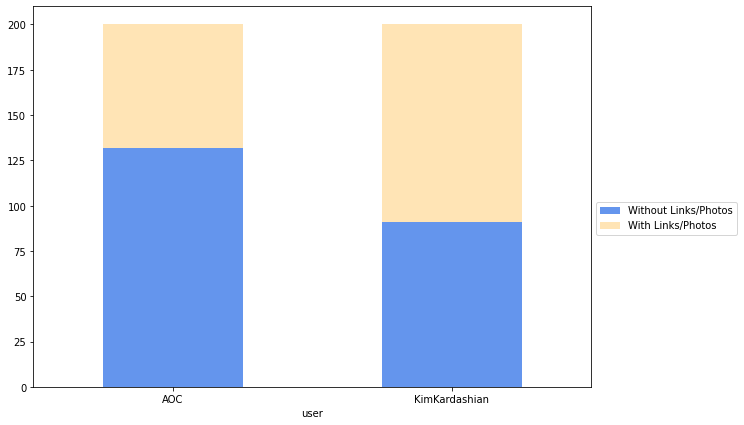

In [7]:
df_ct = pd.crosstab(df.user, df.with_link_or_photo)
df_ct.plot.bar(stacked=True, color=['cornflowerblue', 'moccasin'], figsize=(10, 7))
plt.xticks(rotation=0)
_ = plt.legend(['Without Links/Photos', 'With Links/Photos'], bbox_to_anchor=(1, 0.5))


We can see from the bar plot that more than half of Kim Kardashian's posts or retweets contain links or pictures. Alexandria Ocasio-Cortez's tweets mostly contain texts only.

# **Question 3**: Distribution of Hashtags in Tweets

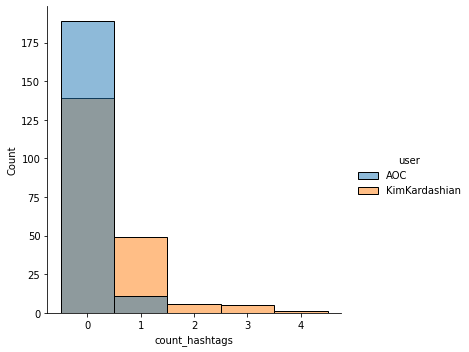

In [8]:
sns.displot(df, x='count_hashtags', hue='user', discrete=True)

Kim Kardashian includes more hashtags on her tweets as compared to Alexandria Ocasio-Cortez.

# Create functions to clean the tweets

In [9]:
def remove_pattern(input_txt, pattern):
  # Create function to remove a pattern using regex
  r = re.findall (pattern, input_txt)
  for i in r:
    input_txt = re.sub(i , '', input_txt)
  return input_txt

# Define tag maps for parts-of-speech tagging
tag_map = defaultdict (lambda : wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV

def clean_tweets(df, user):
  corpus = []
  df = df[df.user==user].reset_index(drop=True)
  for i in range(0, len(df)):
    # Remove links from the tweet text
    tweet = re.sub(r'https?:\/\/\S*', '', df['text'][i], flags = re.MULTILINE)
    # Remove all non-alphanumeric strings in the text
    tweet = re.sub ('[^a-zA-Z0-9]', ' ', tweet)
    word_lemmatized = WordNetLemmatizer()
    # Standardise the text by converting them to lower-case
    tweet = tweet.lower()
    # Remove the retweet (RT) tags
    tweet = re.sub ('rt', '', tweet)
    # Tokenise the text
    tweet = tweet.split()
    # Lemmatise the words and remove stop words
    tweet = [word_lemmatized.lemmatize(word, tag_map[tag[0]]) for word, tag in pos_tag(tweet)
              if not word in set(stopwords.words('english'))]
    if tweet == []:
      corpus.append('')
    else:
      tweet = ' '.join(tweet)
      corpus.append(tweet)
  return corpus

In [10]:
# Remove mentions in the tweet text
df['text'] = np.vectorize(remove_pattern)(df['text'], '@[\w]*')

# Create the corpus for the tweets obtained for AOC and Kim
corpus_aoc = clean_tweets(df, user_1)
corpus_kkw = clean_tweets(df, user_2)

# Create function to create word frequencies

In [11]:
def count_words(df, screen_name, name):
  corpus = clean_tweets(df, screen_name)
  cv = CountVectorizer()
  X = cv.fit_transform(corpus)
  vocab = list(cv.get_feature_names())
  counts = X.sum(axis=0).A1
  df_cv = pd.DataFrame({'words':vocab, name:counts})
  return df_cv

In [12]:
# Create word frequencies for the two users
cv_aoc = count_words(df, user_1, 'AOC')
cv_kkw = count_words(df, user_2, 'Kim_Kardashian')

cv = cv_aoc.merge(cv_kkw, how='outer', on='words').fillna(0)

# Calculate the log odds to get the top word that are mostly associated with each user
cv['log_odds'] = np.log2(((cv.AOC + 1)/(sum(cv.AOC + cv.Kim_Kardashian) + 1)) / ((cv.Kim_Kardashian + 1)/(sum(cv.AOC + cv.Kim_Kardashian) + 1)))
cv['log_pos'] = cv['log_odds'] > 0

Most positive log odds are highly associated with Alexandria Ocasio-Cortez and the most negative log odds are highly associated with Kim Kardashian.

In [13]:
n = 20
max_idx = cv['log_odds'].nlargest(n).reset_index()['index'].values
min_idx = cv['log_odds'].nsmallest(n).reset_index()['index'].values

cv_top20 = pd.concat([cv.iloc[max_idx], cv.iloc[min_idx]])
cv_top20 = cv_top20.sort_values('log_odds', ascending=False).reset_index()

# **Question 4**: List the 20 Words Most Strongly Associated with Each of the Two Users

In [14]:
print('The top 20 words associated to Alexandria Ocasio-Cortez: \n', cv.iloc[max_idx][['words', 'log_odds']])
print('\n')
print('The top 20 words associated to Kim Kardashian: \n', cv.iloc[min_idx][['words', 'log_odds']])

The top 20 words associated to Alexandria Ocasio-Cortez: 
            words  log_odds
1262       trump  3.906891
226      climate  3.807355
304         deal  3.700440
524          gop  3.700440
781         must  3.700440
206       change  3.584963
873       people  3.584963
517         give  3.459432
533        green  3.459432
868          pay  3.459432
1158       state  3.459432
972     question  3.321928
1055       right  3.321928
149        black  3.169925
281        covid  3.169925
130           bc  3.000000
417         even  3.000000
1030         rep  3.000000
1037  republican  3.000000
1094      senate  3.000000


The top 20 words associated to Kim Kardashian: 
             words  log_odds
1547        kuwtk -5.209453
1649         shop -4.000000
1671        style -3.459432
1706       waffle -3.459432
1707         wait -3.459432
1438   collection -3.321928
1444       cotton -3.321928
1471      episode -3.321928
544           guy -3.000000
1376           4x -3.000000
1411         be

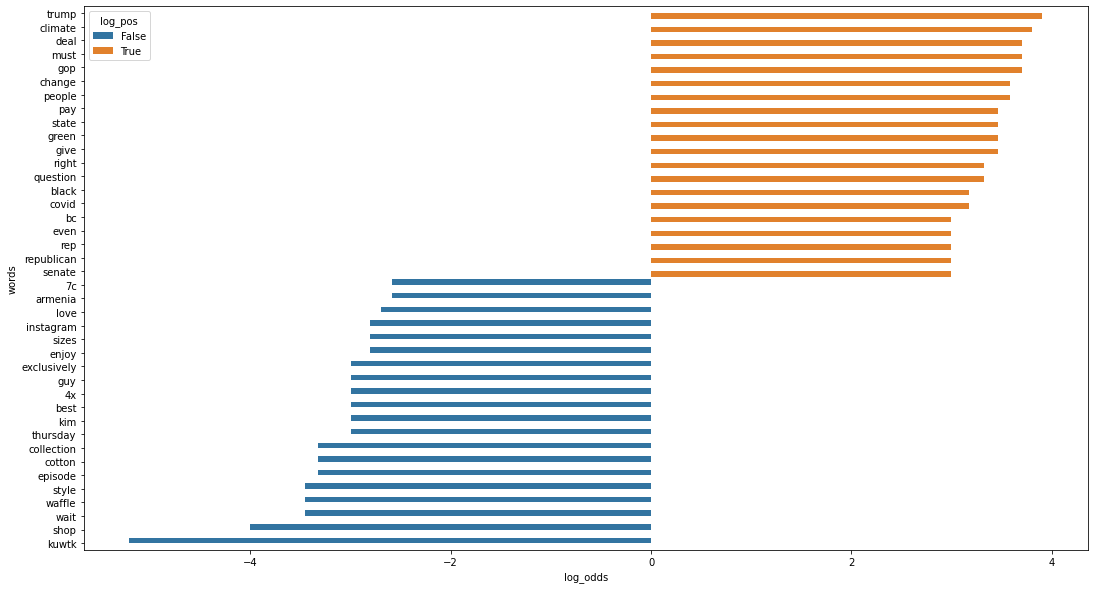

In [15]:
f, ax = plt.subplots(figsize=(18, 10))
_ = sns.barplot(x="log_odds", y="words", data=cv_top20, hue='log_pos')

# **Question 5**: Calculate the Average 'Compound' Sentiment for All Their Tweets

In [16]:
sid = SentimentIntensityAnalyzer()
df['polarity'] = [sid.polarity_scores(tweet) for tweet in df['text']]
df['compound_score'] = [score['compound'] for score in df['polarity']]

In [17]:
comp_score = df.groupby('user').agg({'compound_score': ['mean']})
comp_score.columns = ['mean_compound_score']
comp_score.reset_index()

,user,mean_compound_score
0,AOC,0.052586
1,KimKardashian,0.187066


Kim Kardashian's average compound score is 0.0526 and Alexandria Ocasio-Cortez' average compound score is 0.1871.